In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#3. Modelando Redes Neuronales

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import json
from sqlite3 import dbapi2 as sq3
from pathlib import Path
from collections import OrderedDict

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Activation
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Embedding, Add, Dot, Flatten,Concatenate, Dense
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import plot_model
from sklearn.metrics import mean_squared_error as mse


from time import time
from IPython.display import clear_output

In [4]:
# Connectando a sqlite db
db = sq3.connect('/content/drive/MyDrive/Colab Notebooks/yelp_database.db')

In [5]:
# Funciones para trabajar con SQLite db
def make_query(sel):
    c = db.cursor().execute(sel)
    return c.fetchall()

def make_frame(list_of_tuples, legend):
    framelist=[]
    for i, cname in enumerate(legend):
        framelist.append((cname,[e[i] for e in list_of_tuples]))
    return pd.DataFrame.from_dict(OrderedDict(framelist))

In [6]:
%%time

#Obtener datos para alimentar al modelo
q = make_query("SELECT user_id, business_id, stars FROM reviews")
ratings_df = make_frame(q, legend=['user_id', 'business_id', 'stars'])
del q
ratings_df.head(10)

CPU times: user 1.13 s, sys: 336 ms, total: 1.47 s
Wall time: 6.05 s


,user_id,business_id,stars
0,63411,383,4.0
1,148613,216,1.0
2,48321,753,1.0
3,130613,596,5.0
4,188566,565,5.0
5,181021,273,5.0
6,69899,216,4.0
7,63735,507,5.0
8,98768,652,4.0
9,111619,250,5.0


In [17]:
ratings_df.shape

(378600, 3)

#Predicción de calificaciones mediante filtrado colaborativo con factorización matricial

División de datos

In [7]:
#Train - Val - Test
#80% - 10% - 10%
X_train, X, y_train, y = train_test_split(ratings_df.drop('stars', axis=1), ratings_df.stars, train_size=.8)
X_test, X_val, y_test, y_val = train_test_split(X, y, train_size=.5)
del X, y

print(f"Train Size: {round(X_train.shape[0]/ratings_df.shape[0]*100)}%")
print("X train shape: ", X_train.shape)
print("y train shape: ", y_train.shape)

print(f"\nValidation Size: {round(X_val.shape[0]/ratings_df.shape[0]*100)}%")
print("X val   shape: ", X_val.shape)
print("y val   shape: ", y_val.shape)

print(f"\nTest Size: {round(X_test.shape[0]/ratings_df.shape[0]*100)}%")
print("X test  shape: ", X_test.shape)
print("y test  shape: ", y_test.shape)

Train Size: 80%
X train shape:  (302880, 2)
y train shape:  (302880,)

Validation Size: 10%
X val   shape:  (37860, 2)
y val   shape:  (37860,)

Test Size: 10%
X test  shape:  (37860, 2)
y test  shape:  (37860,)


In [8]:
# Funciones auxiliares
def create_bias(name, inp, n_in, reg):
    #x = Embedding(n_in, 1, input_length=1, embeddings_regularizer=l2(reg))(inp)
    x = Embedding(n_in, 1, input_length=1, name=name)(inp)
    return Flatten(name=name+'_flat')(x)
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, name=name.split('_')[0]+'_factor', embeddings_regularizer=l2(reg))(inp)

def sigmoid_maker(low, high):
    def custom_sigmoid(x):
        return K.sigmoid(x)*(high - low) + low #al alcance
    return custom_sigmoid

In [9]:
#  Obtener datos comerciales y de usuario únicos y totales
nbusiness = make_query("SELECT COUNT(*) FROM businesses")[0][0]
nusers = make_query("SELECT COUNT(*) FROM users")[0][0]
print("Number of Business:", nbusiness)
print("Number of Users:", nusers)

Number of Business: 7970
Number of Users: 1987897


#Precisión de referencia promedio

El modelo promedio siempre predice el promedio de todas las calificaciones. Esto nos da un número que intentaremos mejorar.

In [10]:
#Precisión de referencia
mean_rating = y_train.mean()

train_baseline = mse(y_train, [mean_rating]*y_train.shape[0])
val_baseline = mse(y_val, [mean_rating]*y_val.shape[0])
test_baseline = mse(y_test, [mean_rating]*y_test.shape[0])


print(f"""MSE de referencia utilizando la calificación media:\n
          Train Data: {train_baseline:.4f},
          Val   Data: {val_baseline:.4f},
          Test  Data: {test_baseline:.4f}""")

Baseline MSE using mean rating:

          Train Data: 2.1537,
          Val   Data: 2.1538,
          Test  Data: 2.1725


#Sistema de recomendación lineal
Aquí utilizamos el producto escalar de incrustaciones y agregamos sesgos de usuario y de negocio antes de pasar por sigmoide.

In [41]:
L = 50
REG = 1e-2

user_input, uLmat = embedding_input('user_input', nusers, L, REG)
business_input, mLmat = embedding_input('bussines_input', nbusiness, L, REG)
user_bias = create_bias('user_bias', user_input, nusers, REG)
business_bias = create_bias('business_bias', business_input, nbusiness, REG)

residual = Dot(axes=2, name="residual")([uLmat, mLmat])
residflat = Flatten(name="residual_flat")(residual)
regression = Add(name="regression")([user_bias, business_bias, residflat])

cs = sigmoid_maker(0, 5.5)
output = Activation(cs, name="Sigmoid_Range")(regression)
model = Model([user_input, business_input], output)
model.compile(Adam(.01), loss='mse')

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 bussines_input (InputLayer  [(None, 1)]                  0         []                            
 )                                                                                                
                                                                                                  
 user_factor (Embedding)     (None, 1, 50)                9939485   ['user_input[0][0]']          
                                                          0                                       
                                                                                            

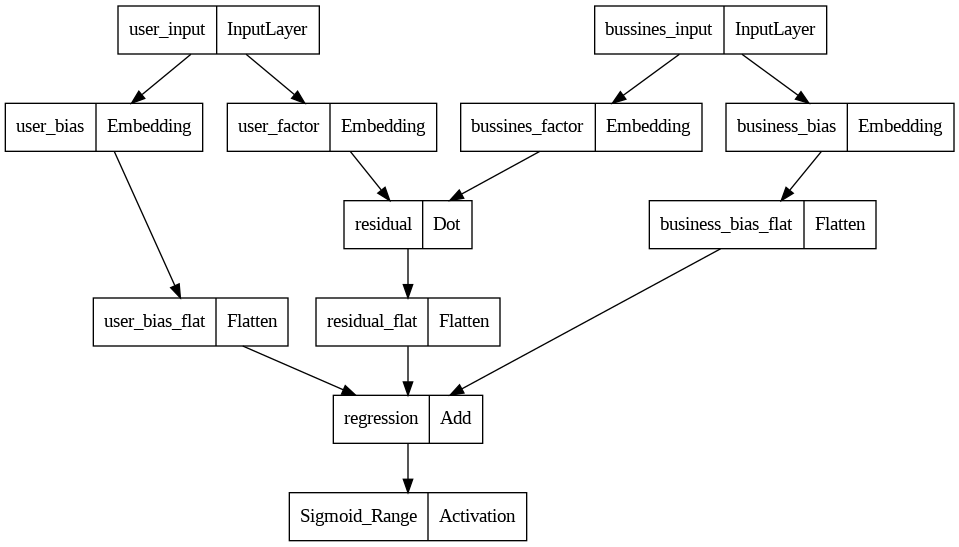

In [42]:
plot_model(model)

In [27]:
#Entrenando Modelo
model.optimizer.learning_rate = 5e-2
h1 = model.fit([X_train.user_id, X_train.business_id], y_train, epochs=2,
              validation_data=([X_val.user_id, X_val.business_id], y_val), batch_size=1024, verbose=1)

# model.optimizer.learning_rate = 5e-3
# h2 = model.fit([X_train.user_id, X_train.business_id], y_train, epochs=1,
#               validation_data=([X_val.user_id, X_val.business_id], y_val), batch_size=512, verbose=2)

Epoch 1/2
296/296 [==============================] - 389s 1s/step - loss: 22.2699 - val_loss: 1.6244
Epoch 2/2
296/296 [==============================] - 384s 1s/step - loss: 1.1071 - val_loss: 1.6907


Text(0.5, 1.0, 'Loss Plot')

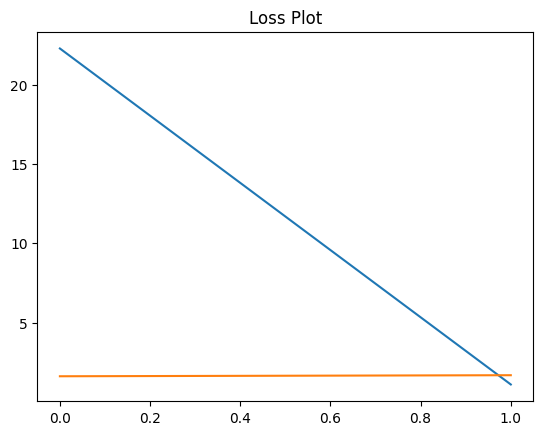

In [28]:
# Graficando Train and Val loss

loss = h1.history['loss']#+h2.history['loss']
val_loss = h1.history['val_loss']#+h2.history['val_loss']
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.title('Loss Plot')

In [43]:
#Guardando model
model.save('Linear_Model')

### Sistema de recomendación no lineal
Aquí usamos una combinación no lineal de incrustaciones apilándolas y pasando por FFNN y luego agregamos sesgo de usuario y sesgo antes de pasar por sigmoide.

In [34]:
L = 50
REG = 1e-2

In [37]:
#Parámetros de capa densa
hidden_layers = 4
activation = 'relu'
n_neurons = 32
dense_reg = 1e-2


user_input, uLmat = embedding_input('user_input', nusers, L, REG)
business_input, mLmat = embedding_input('business_input', nbusiness, L, REG)
user_bias = create_bias('user_bias', user_input, nusers, REG)
business_bias = create_bias('business_bias', business_input, nbusiness, REG)

x = Concatenate()([Flatten()(uLmat), Flatten()(mLmat)])
for _ in range(hidden_layers):
    x = Dense(n_neurons, activation=activation, kernel_regularizer=l2(dense_reg))(x)
x = Add(name="regression")([user_bias, business_bias, x])
output = Dense(1, activation=sigmoid_maker(0.5, 5.5), name="Sigmoid_Range")(x)

model2 = Model([user_input, business_input], output)
model2.compile(Adam(1e-2), loss='mse')

model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 business_input (InputLayer  [(None, 1)]                  0         []                            
 )                                                                                                
                                                                                                  
 user_factor (Embedding)     (None, 1, 50)                9939485   ['user_input[0][0]']          
                                                          0                                       
                                                                                            

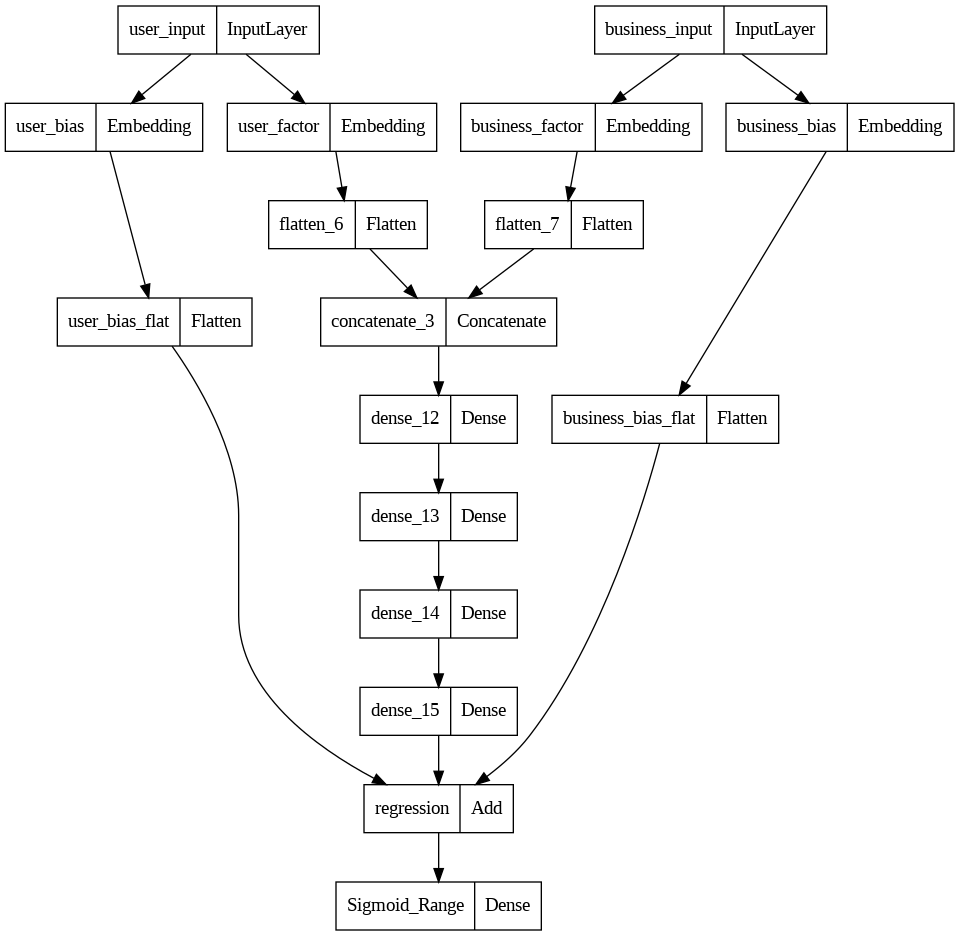

In [38]:
plot_model(model2)

In [39]:
#Entrenando model
model2.optimizer.learning_rate = 5e-2
h1 = model2.fit([X_train.user_id, X_train.business_id], y_train, epochs=2,
              validation_data=([X_val.user_id, X_val.business_id], y_val), batch_size=1024)

# model2.optimizer.learning_rate = 5e-3
# h2 = model2.fit([X_train.user_id, X_train.business_id], y_train, epochs=2,
#               validation_data=([X_val.user_id, X_val.business_id], y_val), batch_size=512)

# model2.optimizer.learning_rate = 1e-4
# h3 = model2.fit([X_train.user_id, X_train.business_id], y_train, epochs=2,
#               validation_data=([X_val.user_id, X_val.business_id], y_val), batch_size=2048)

Epoch 1/2
296/296 [==============================] - 812s 3s/step - loss: 22.2148 - val_loss: 1.6068
Epoch 2/2
296/296 [==============================] - 827s 3s/step - loss: 1.1098 - val_loss: 1.7346


Text(0.5, 1.0, 'loss plot')

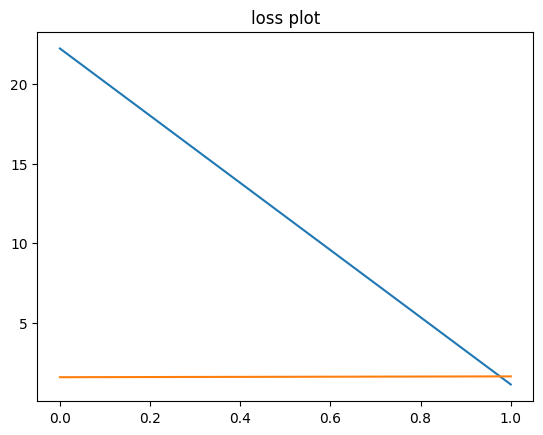

In [14]:
loss = h1.history['loss']#+h2.history['loss']+h3.history['loss']
val_loss = h1.history['val_loss']#+h2.history['val_loss']+h3.history['val_loss']
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.title('loss plot')

In [16]:
model2.save('Nonlinear_Model')

#Implementación del sistema de recomendación no lineal
Aquí escribiremos una función que toma user_id como entrada y devuelve recomendaciones personalizadas, al igual que los sitios web reales.

In [15]:
# Getting all the necessary Data
table = make_query("SELECT user_id, business_id, stars FROM reviews")
reviews_df = make_frame(table, ['user_id', 'business_id', 'rating'])

table = make_query("SELECT business_id, name, address, city, state, postal_code, latitude, longitude, stars\
                   FROM businesses")
business_df = make_frame(table, "business_id, name, address, city, state, postal_code, latitude, longitude, stars".split(', '))

del table

Nuestra red neuronal es de tamaño muy grande, no pondremos todos los negocios a la vez para un solo usuario, esto resultaría en una recomendación lenta.

Utilizamos la generación de candidatos, que analiza el historial de un usuario, infiere su ubicación, encuentra el mejor negocio en su ubicación y también analiza el negocio favorito de sus amigos. Estas empresas ahora son candidatas que podrían gustarle al usuario.

Estos candidatos ahora pasan por nuestro modelo que los clasifica según la calificación prevista.

In [17]:
# Esta celda tiene función de generación de candidatos.

def generate_candidates(user_id, friend=False):
    """
 Devuelve una lista de identificaciones comerciales que podrían ser buenas perspectivas para un usuario en particular.
    Factores en la ubicación y las elecciones de amigos del usuario.

    Parámetros:
    user_id: identificación del usuario
    amigo: llamada recursiva para conseguir amigos del usuario. Solo llamadas internas

    Devolver:
    lst: lista de identificadores de empresas. No está vacío
    """
    lst = []
    top_candidates_by_city = 20
    top_candidates_by_frnd = 10

    # Por Locación
    #todo lo que el usuario  ha visitado anteriormente
    user_history = reviews_df.query(f'user_id=={user_id}')
    if user_history.shape[0]!=0:
        # Detalles sobre esos restaurantes.ts
        visit_history = business_df.query(f'business_id in {list(user_history.business_id)}')
       # Implicando que el usuario vive en la ciudad al observar la ciudad más frecuente en la historia.
        #Esto permitirá que nuestra recomendación personalice las recomendaciones para el usuario.
        city_mode = visit_history.city.mode()

        if not friend:
            for city in city_mode:
                city_df = business_df.query(f'city == "{city}"').sort_values(by='stars', ascending=False)[:400]
                lst.extend(city_df.business_id[:top_candidates_by_city].values)

     ##Si la devolución de llamada recursiva tiene una calificación alta  por parte de un amigo
        else:
            frnd_favourite =  visit_history.sort_values(by='stars', ascending=False).business_id.values[:top_candidates_by_frnd]
            lst.extend(frnd_favourite)
            return lst

    # negocio que le gusta a sus amigos
    frnd_lst = eval(make_query(f"SELECT friends FROM users WHERE user_id={user_id}")[0][0])

    for frnd in frnd_lst:
        # LLmada recursiva
        # retorna empresa en la que un friend ha visitado y  ha calificado alto
        frnd_recom = generate_candidates(frnd, friend=True)
        lst.extend(frnd_recom)

    #Si la lista no está vacia
    if lst:
        #Retorna entradas unicas
        return list(set(lst))

    # La lista está vacía Por lo tanto, el usuario es un solitario.
    return loner_user()

def loner_user():
    """
   Un usuario es un solitario si no tiene amigos y no ha valorado ningún negocio. Para dichos usuarios haremos
   Generar candidatos en función de las calificaciones de la base empresarial (sesgos empresariales).
    Podría ser un usuario nuevo en el sitio que no ha interactuado mucho.

    Devolver:
    lst: lista de identificadores de empresas. No está vacío
    """
    return_top = 20
    restaurant_bias = model2.get_layer('business_bias').weights[0].numpy()
    bias_df = pd.DataFrame(restaurant_bias, columns=['business_bias'])
    bias_df.index.name='business_id'
    bias_df = bias_df.sort_values(by='business_bias', ascending=False)

    return bias_df.index[:return_top].tolist()

#Mejoras
#La generación de candidatos se puede mejorar agregando argumentos explícitos para la ciudad y el tipo de categoría empresarial.

In [56]:
generate_candidates(user_id=2)

[1782,
 3799,
 6302,
 4110,
 892,
 898,
 1568,
 6144,
 7323,
 5321,
 6818,
 6242,
 4862,
 4186,
 6694,
 1238,
 112,
 4172,
 3631,
 5210]

In [18]:
#Envolviendo nuestro modelo para simplificar su uso.
def recommend(user_id, top=50):
    """
   Utiliza el sistema de recomendación para recomendar negocios al usuario.

    Parámetros:
    user_id: identificación del usuario
    arriba: Número de recomendaciones [50 por defecto]

    Devoluciones:
    id_lst: Lista de identificadores de empresas. Tamaño de la lista = superior
    pred_ratings: Lista de calificaciones para la identificación comercial correspondiente. Tamaño de la lista = superior
    """

    label = f"predicted_rating_user_id_{user_id}"
    candidates = generate_candidates(user_id=user_id)
    pred_ratings = model2.predict([np.array([user_id]*len(candidates)), np.array(candidates)])
    pred_ratings = np.floor(pred_ratings*2)/2
    pred_df = pd.DataFrame({'business_id':candidates, label:pred_ratings.ravel()})
    df = business_df.query(f'business_id in {candidates}')
    return df.merge(pred_df, on='business_id').sort_values(by=label, ascending=False).head(top)

In [33]:


recommend(user_id=98768)

2/2 [==============================] - 0s 12ms/step


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,predicted_rating_user_id_98768
38,7780,European Flavors,648 Oakfield Dr,Brandon,FL,33511,27.935189,-82.293014,5.0,5.0
39,7875,Nadal Pediatrics,621 Victoria St,Brandon,FL,33510,27.944805,-82.293245,5.0,4.5
12,2808,"Wayne Lee, MD","1020 E Brandon Blvd, Ste 101",Brandon,FL,33511,27.938735,-82.267296,5.0,4.5
28,6200,FR Bottle Shop,1937 W Brandon Blvd,Brandon,FL,33511,27.936759,-82.315860,5.0,4.5
23,5170,Pink Butterfly Bush V-Steam Lounge,"1025 Professional Park Dr, Ste 2",Brandon,FL,33511,27.920275,-82.323956,5.0,4.5
21,4972,Brandon Dental Care,"413 W Robertson St, Ste C",Brandon,FL,33511,27.935399,-82.290132,5.0,4.5
1,1138,South Pacific Grill,112 Pauls Dr,Brandon,FL,33511,27.936634,-82.302738,5.0,4.5
18,3620,Annie Tea House,1924 W Brandon Blvd,Brandon,FL,33511,27.938213,-82.316302,5.0,4.5
17,3577,Sun Bar Tanning Saloon,1029 W Brandon Blvd,Brandon,FL,33511,27.936067,-82.299829,5.0,4.5
16,3480,"Mark D Mellman DDS, PA",721 W Robertson St,Brandon,FL,33511,27.935501,-82.295794,5.0,4.5


In [26]:
recommend(user_id=130613)

1/1 [==============================] - 0s 22ms/step


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,predicted_rating_user_id_130613
10,3485,First Quality Sausage House,"605 9th Ave N, Ste A",Safety Harbor,FL,34695,27.996049,-82.696908,5.0,5.0
2,747,Bassano Cheesecake Cafe,507 Main St,Safety Harbor,FL,34695,27.990914,-82.692414,4.5,5.0
4,1076,Miss Hazels Kitchen,603 Elm St,Safety Harbor,FL,34695,27.995833,-82.703319,4.5,5.0
5,2313,Troubled Waters Brewing,670 Main St,Safety Harbor,FL,34695,27.990501,-82.693932,4.5,5.0
7,3013,Safety Harbor Therapeutic Massage Center,"500 Main Street, Ste H",Safety Harbor,FL,34695,27.990630,-82.692513,5.0,5.0
8,3018,Harbor Food Tours,401 Main St,Safety Harbor,FL,34695,27.990932,-82.691364,5.0,5.0
16,6755,Kilos Kava & Tea Bar,660 2nd St S,Safety Harbor,FL,34695,27.990221,-82.694020,5.0,5.0
15,6751,Sno Beach,310 Main St,Safety Harbor,FL,34695,27.990674,-82.690346,4.5,5.0
13,5535,Pizza Cones,"500 Main St, Ste C",Safety Harbor,FL,34695,27.990634,-82.692517,4.5,4.5
18,7298,Southern Fresh,122 3rd Ave N,Safety Harbor,FL,34695,27.991208,-82.689986,4.5,4.5


#Comparando modelos
Compararemos el rendimiento de los 3 modelos: promedio, lineal y no lineal.

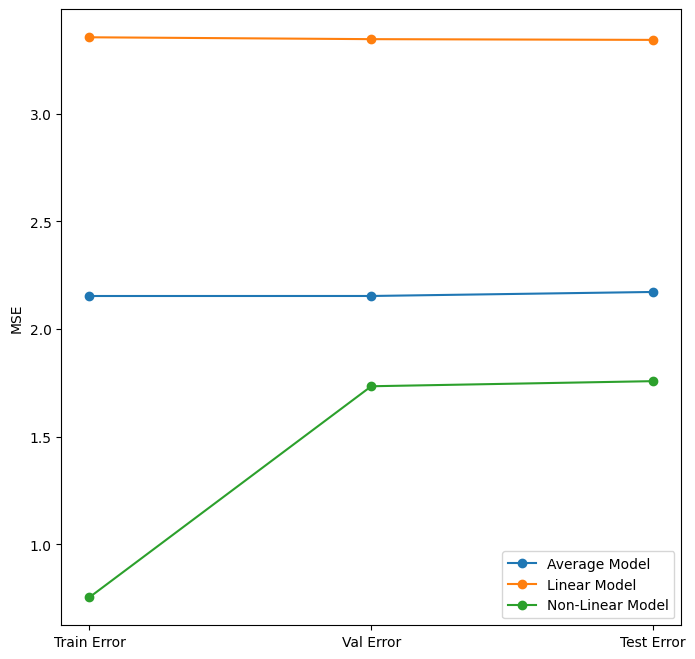

In [44]:
#Calculando MSE
ticks = ["Train", "Val", "Test"]
avg_model = [train_baseline, val_baseline, test_baseline]
linear_model, non_linear_model = [], []
for data in [(X_train, y_train), (X_val, y_val), (X_test, y_test)]:
    lin_mse = mse(data[1], model.predict([data[0]['user_id'],data[0]['business_id']], verbose=1))
    linear_model.append(lin_mse)

    nonlin_mse = mse(data[1], model2.predict([data[0]['user_id'],data[0]['business_id']], verbose=1))
    non_linear_model.append(nonlin_mse)

    clear_output()

#Plotear Modelwise Error
plt.figure(figsize=(8,8))
ax = plt.gca()

ax.plot(avg_model, "o-", label="Average Model")
ax.plot(linear_model, "o-", label="Linear Model")
ax.plot(non_linear_model, "o-", label="Non-Linear Model")

ax.set(xlabel='', ylabel='MSE', xticks=[0,1,2], xticklabels=["Train Error", "Val Error", "Test Error"])
ax.legend()

El rendimiento del modelo se puede mejorar mediante capacitación adicional. Podemos probar capas más densas para una combinación no lineal de incrustaciones.

#Conclusión
Creamos una red neuronal y mejoramos las métricas de referencia,
analizamos nuevos negocio, a la competencia y a los usuarios.